In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
sns.set(color_codes=True)
sns.set_palette(sns.color_palette("husl", 8));
# see http://matplotlib.org/users/customizing.html
sns.mpl.rc("figure", figsize=(16,4)) # sns.set_style({'figure.figsize' : (16,4)})
plt.rcParams['savefig.dpi'] = 150

In [2]:
cd ../

/Users/toz/Documents/workspace/Circle-of-Doom


# Part 1

In [3]:
# Published News (retrieved from Lexis Nexis)
pn = pd.read_csv('data/ln-sp.csv')

In [4]:
# Tweeted News
tn = pd.read_csv('data/tw-sp.csv',usecols=['dt', 'outlet', 'rt', 'sp'])

In [5]:
# Retweeted News
rn = pd.DataFrame(columns=tn.columns)
for row in tn.iterrows():
    rn = rn.append(pd.DataFrame([row[1]]*int(1 + row[1].rt/50)))

In [6]:
outlets = sorted(pn['outlet'].unique().tolist())
tn = tn.drop('rt',axis=1)
rn = rn.drop('rt',axis=1)

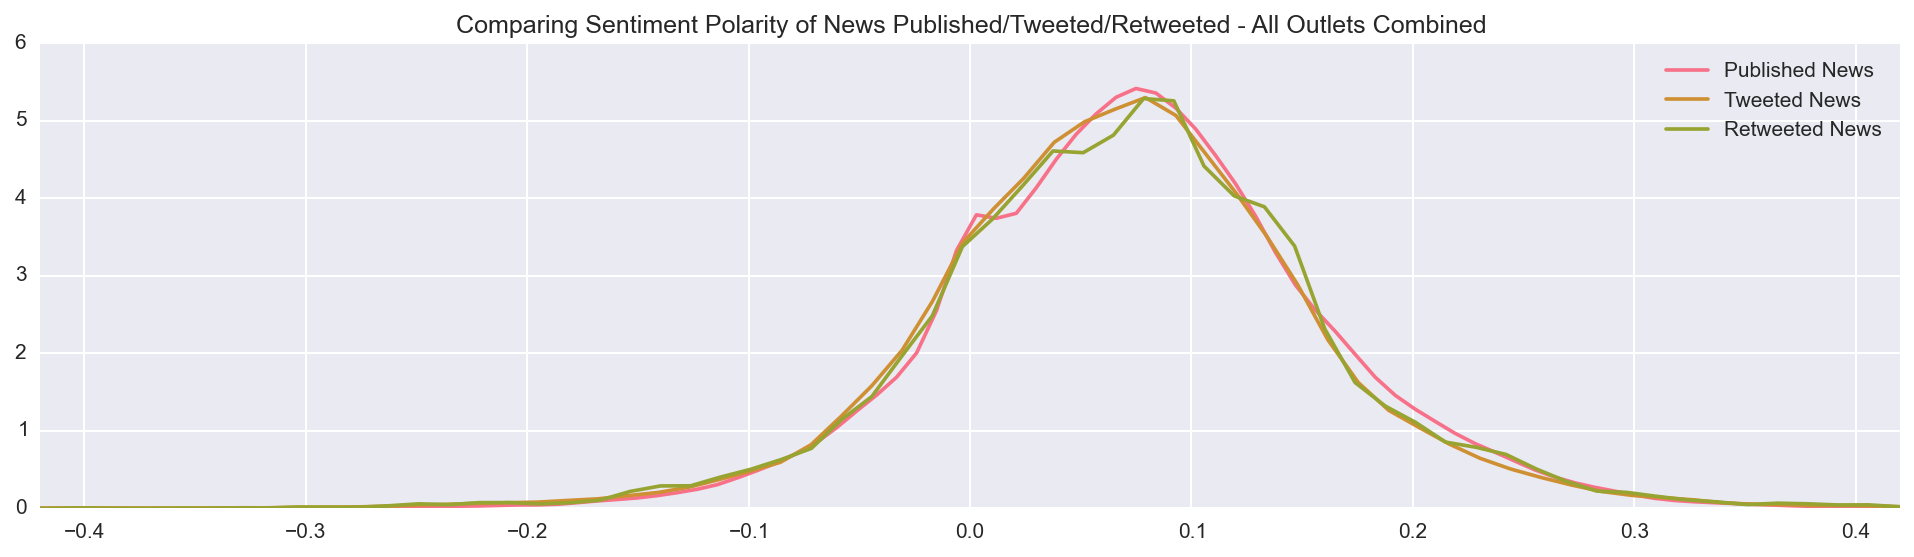

In [7]:
splim=(-.42, .42)
sns.kdeplot(pn['sp'],label='Published News').set(xlim=splim);
sns.kdeplot(tn['sp'],label='Tweeted News').set(xlim=splim);
ax = sns.kdeplot(rn['sp'],label='Retweeted News')
ax.set_title('Comparing Sentiment Polarity of News Published/Tweeted/Retweeted - All Outlets Combined');

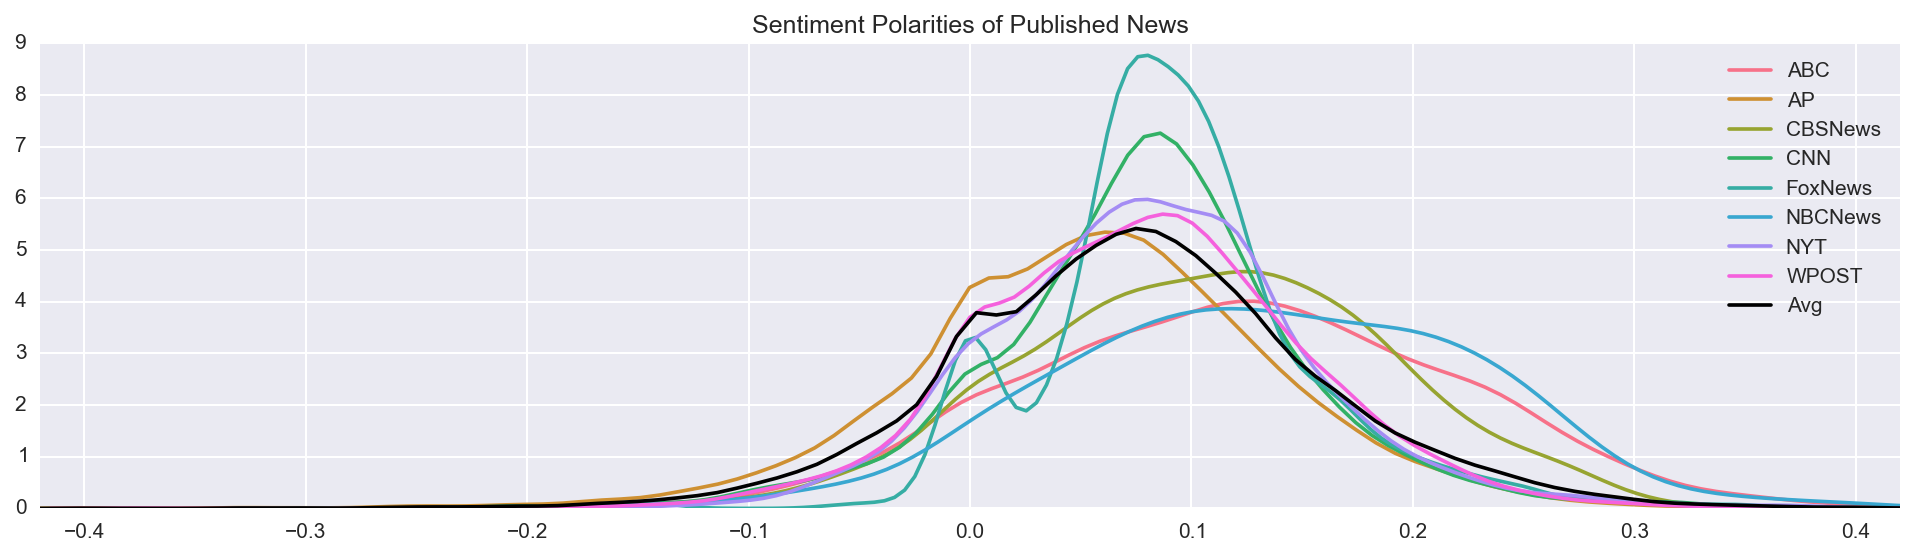

In [8]:
df = pn
[sns.kdeplot(df[df['outlet']==o]['sp'],label=o).set(xlim=splim) for o in outlets];
ax = sns.kdeplot(df['sp'],label='Avg',color='black')
ax.set_title('Sentiment Polarities of Published News');

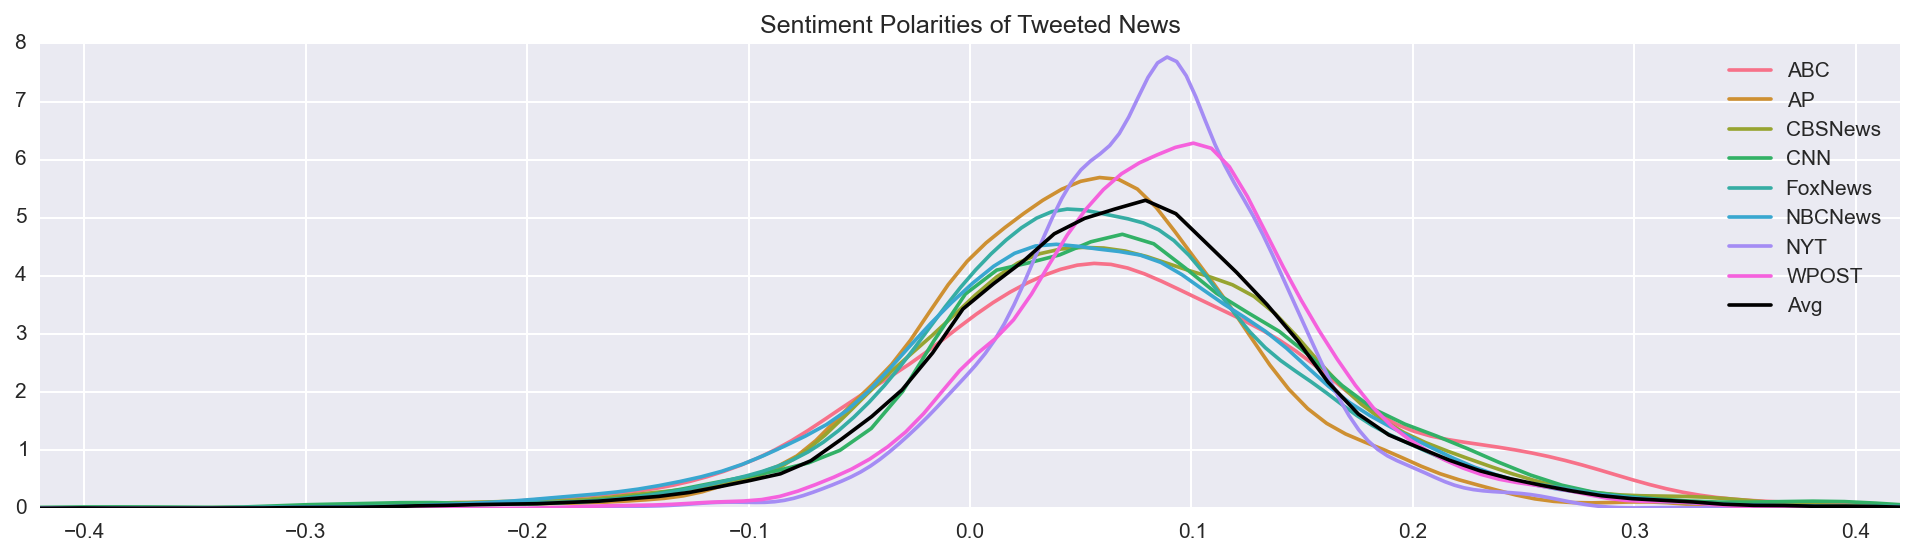

In [9]:
df = tn
[sns.kdeplot(df[df['outlet']==o]['sp'],label=o).set(xlim=splim) for o in outlets];
ax = sns.kdeplot(df['sp'],label='Avg',color='black')
ax.set_title('Sentiment Polarities of Tweeted News');

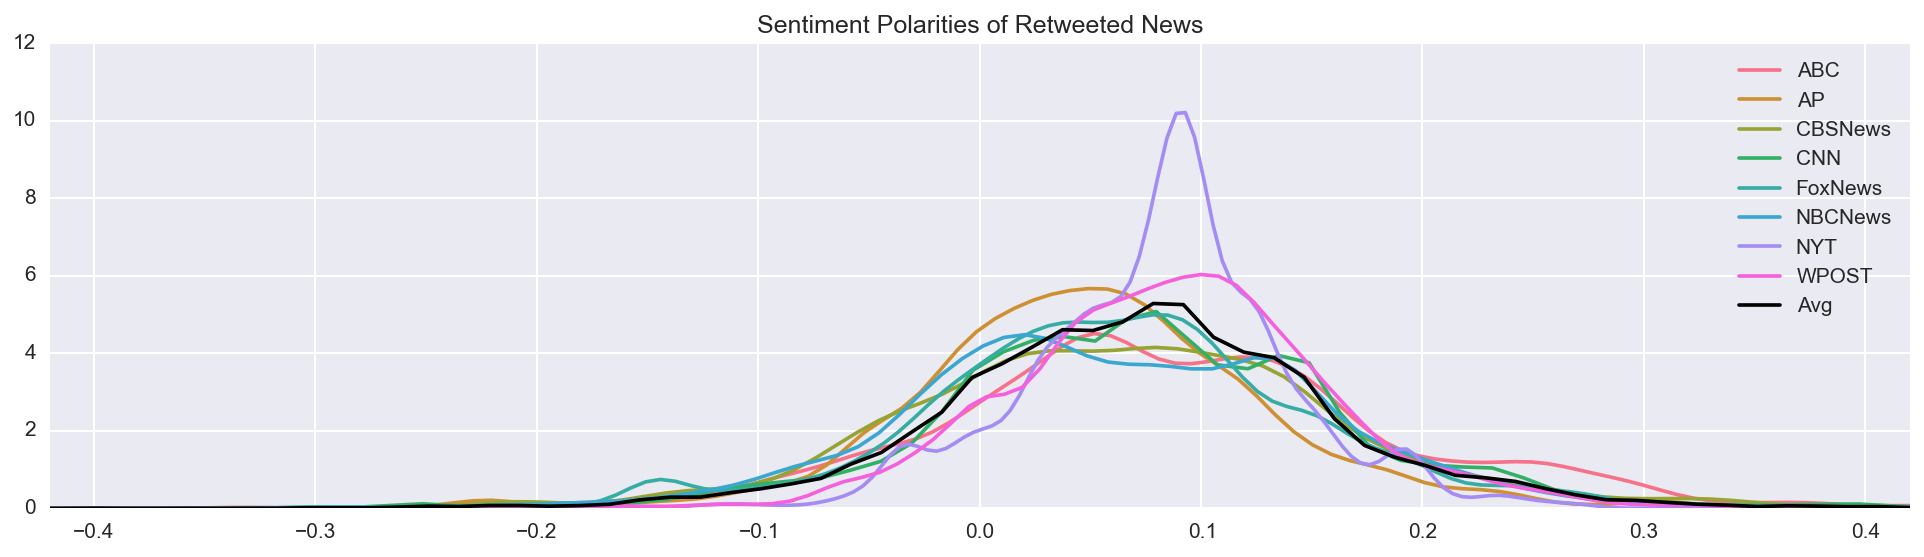

In [10]:
df = rn
[sns.kdeplot(df[df['outlet']==o]['sp'],label=o).set(xlim=splim) for o in outlets];
ax = sns.kdeplot(df['sp'],label='Avg',color='black')
ax.set_title('Sentiment Polarities of Retweeted News');

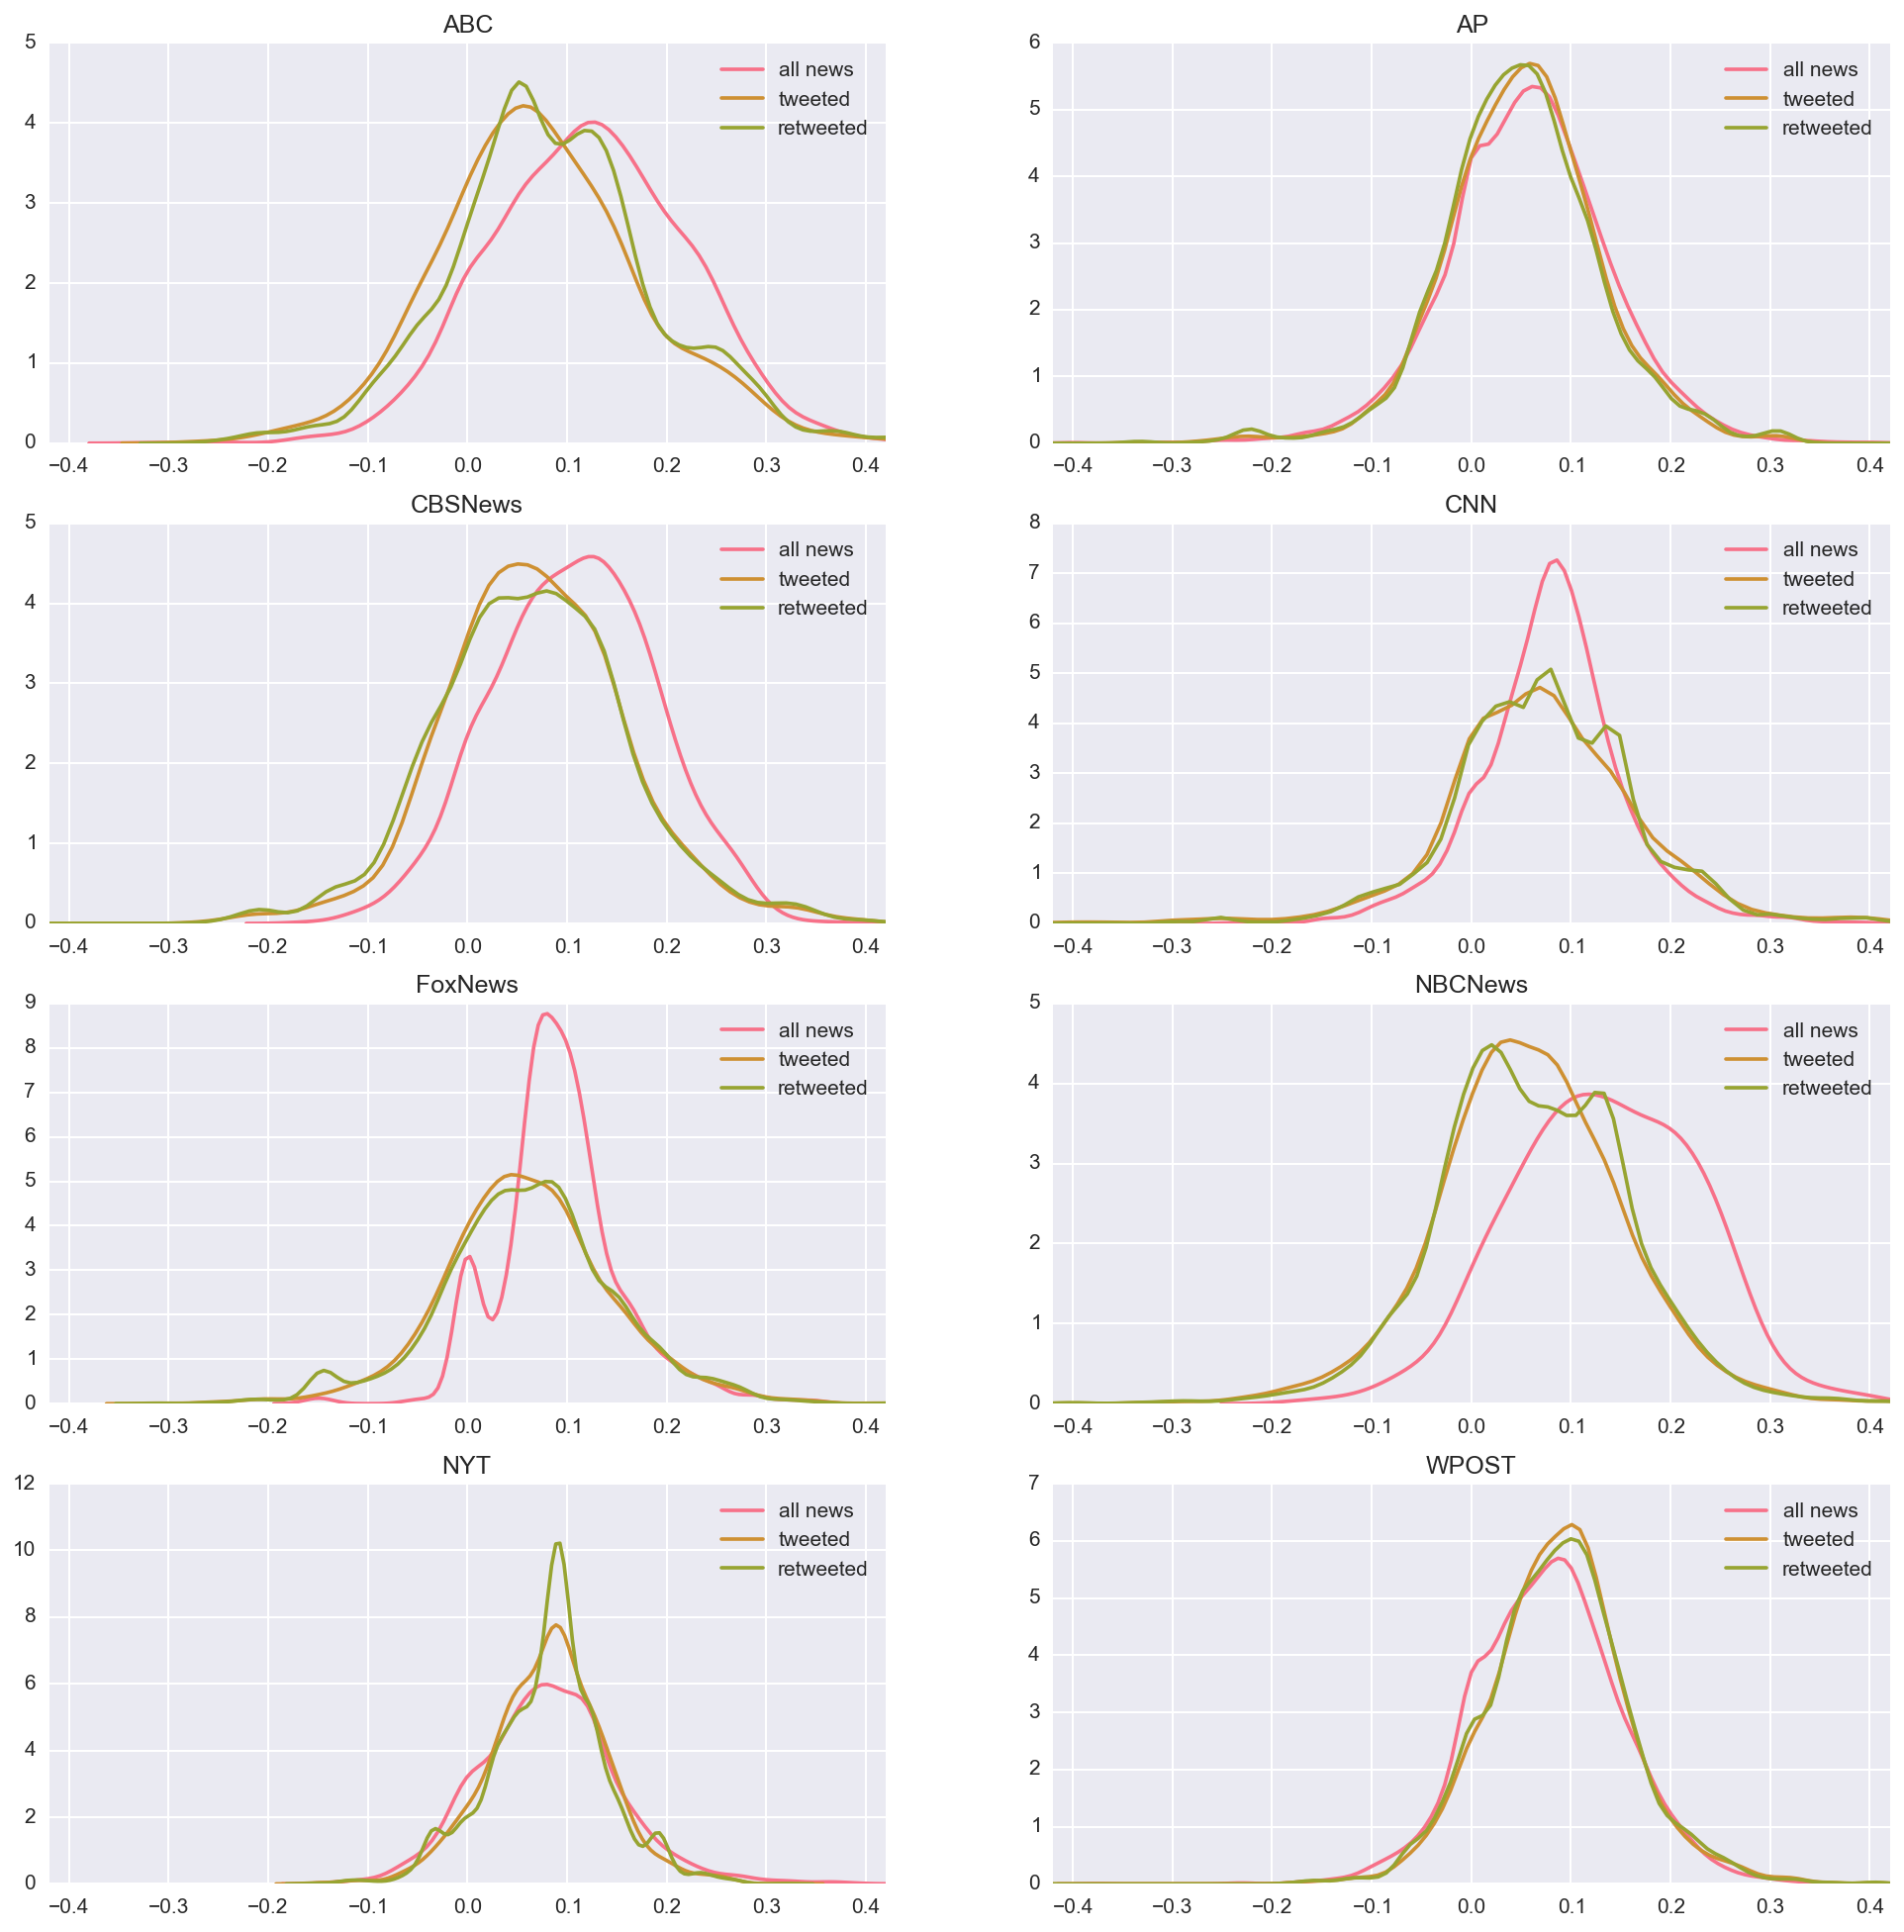

In [11]:
# Each outlet in a separate plot
f,axes = plt.subplots(nrows=4,ncols=2,figsize=(16,16),subplot_kw={'xlim': splim});#,sharex=True,sharey=True
for i,o in enumerate(outlets):
    ax = axes[i/2][i%2]
    ax.set_title(o)
    sns.kdeplot(pn[pn['outlet']==o]['sp'],label='all news',ax=ax)
    sns.kdeplot(tn[tn['outlet']==o]['sp'],label='tweeted',ax=ax)
    sns.kdeplot(rn[rn['outlet']==o]['sp'],label='retweeted',ax=ax)

In [12]:
df = pd.pivot_table(pn,index=['outlet'],values=['sp'],aggfunc=np.mean).rename(columns={'sp':'Published'})
df = df.join(pd.pivot_table(tn,index=['outlet'],values=['sp'],aggfunc=np.mean).rename(columns={'sp':'Tweeted'}))
df = df.join(pd.pivot_table(rn,index=['outlet'],values=['sp'],aggfunc=np.mean).rename(columns={'sp':'Retweeted'}))
df

,Published,Tweeted,Retweeted
outlet,,,
ABC,0.121289,0.073424,0.086552
AP,0.056630,0.052039,0.049722
CBSNews,0.107229,0.068442,0.065489
CNN,0.079748,0.071030,0.074590
FoxNews,0.092249,0.061333,0.065008
NBCNews,0.133630,0.058080,0.062377
NYT,0.081869,0.080523,0.081503
WPOST,0.076985,0.087476,0.086371


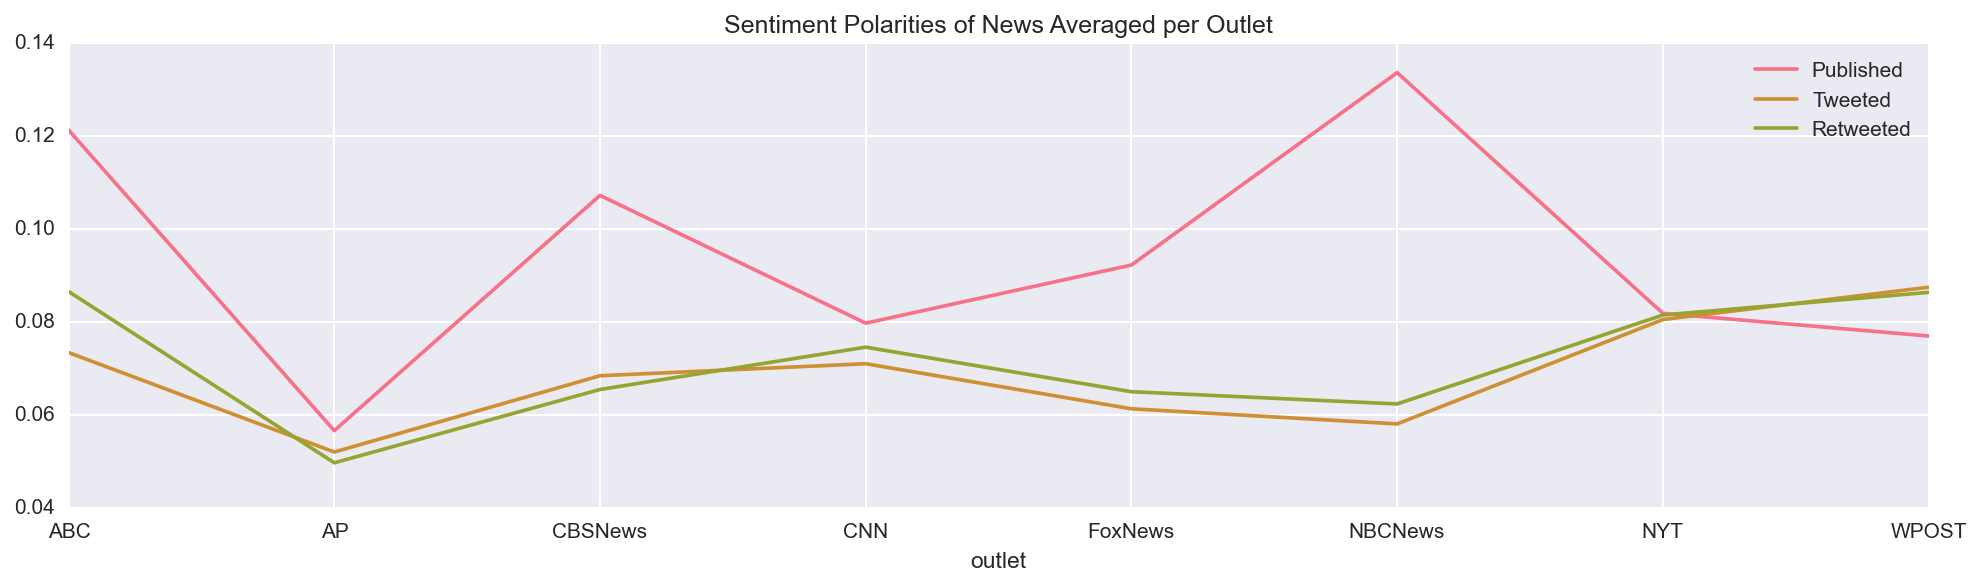

In [13]:
ax = df.plot()
ax.set_title('Sentiment Polarities of News Averaged per Outlet');

#Part 2

In [70]:
def getCat(x):
    pieces = [piece.lower() for piece in x.href.split('/')]
    
    if x.outlet == 'CNN':
        return pieces[-3]
    elif x.outlet == 'NYT':
        if pieces[-2]=='international':
            return 'world'
        if 'ball' in pieces[-2]:
            return 'sports'
        return pieces[-2]
    elif x.outlet == 'ABC':
        if pieces[3]=='international':
            return 'world'
        return pieces[-3]
    elif x.outlet == 'NBCNews':
        if pieces[3]=='news':
            return pieces[4] if pieces[4]!='us-news' else 'us'
        if pieces[3]=='meet-the-press':
            return 'interview'
        return pieces[3]
    elif x.outlet == 'CBSNews':
        return pieces[-3]
    elif x.outlet == 'FoxNews':
        return pieces[3]
    elif x.outlet == 'AP':
        return pieces[-3]
    elif x.outlet == 'WPOST':
        return pieces[3] if pieces[3]!='pb' else pieces[4]

df = pd.read_csv('data/tw-sp.csv')
print('Header:',', '.join(df.columns.values))
print('Number of rows and columns:',df.shape)
df = df[~df.href.str.contains('/videos/')] #CNN
df = df[(df.outlet != 'FoxNews') | ((df.outlet == 'FoxNews') & (df.href.str.contains('www.foxnews.com')))] #Fox
df['cats'] = df.apply(getCat,axis=1)
category = pd.pivot_table(df,index=["cats"],values=["href"],aggfunc=len).sort('href',ascending=False)
bf= df[df.cats.isin(category[category.href>50].index)]
b = pd.pivot_table(bf,index=["cats"],columns=['outlet'],values=["href"],aggfunc=len)
b.fillna('')

Header: dt, outlet, rt, fav, sp, href
Number of rows and columns: (16530, 6)


href                                              
outlet         ABC    AP CBSNews  CNN FoxNews NBCNews  NYT WPOST
cats                                                            
americas                           23                   31      
article             1868                                        
asia                               60               2   82      
blogs                                                       1237
business        47                  1             160   72    27
economy                            37                   27      
entertainment  123                112     157                 14
europe                             61               5  109      
health         166                 59     101      81   25      
interview                                          83           
leisure                                    57                   
lifestyle       68                                            65
living                             85                           
local                                                         97
magazine                                               108      
media                              45                   29      
middleeast                         74                  106      
news             1          1952   15                        756
nyregion                                               177      
opinion                            46      37           55      
politics       156                323     515      78  112   139
pop-culture                                        69           
science                                    45     145   54      
sports          52                         60      31  107     9
storyline                                         411           
tech                               18      54     122           
technology     108                 51                   41      
travel          16                 34      16           38      
upshot                                                  75      
us             507                351     475     739  264      
weather                                    24      54           
world          265                109     334     384   57   210

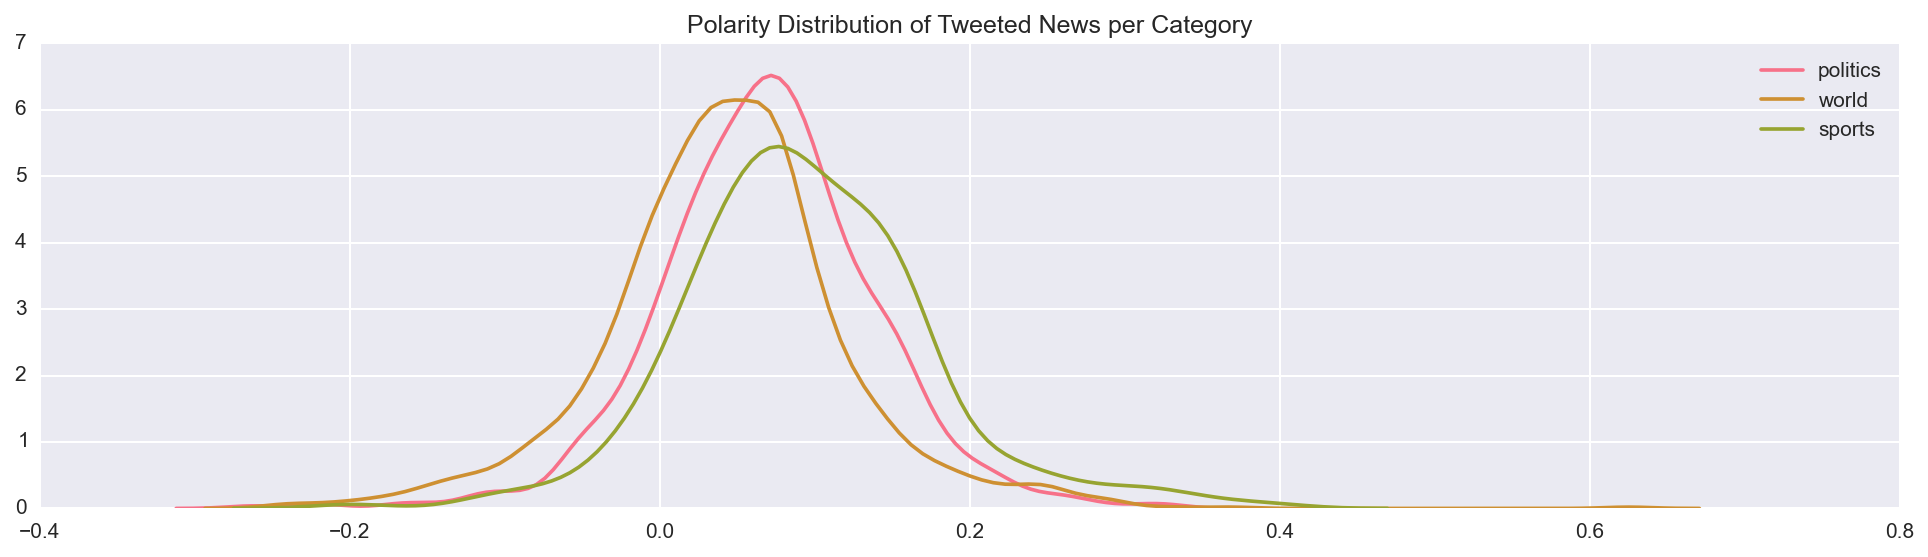

In [15]:
cs = ['politics','world','sports']
ax = [sns.kdeplot(df[df['cats']==c]['sp'],label=c) for c in cs][0]
ax.set_title('Polarity Distribution of Tweeted News per Category');

In [17]:
# Retweeted News
rn = pd.DataFrame(columns=df.columns)
for row in df.iterrows():
    rn = rn.append(pd.DataFrame([row[1]]*int(1 + row[1].rt/50)))

In [22]:
outlets.remove('AP')
outlets.remove('CBSNews')

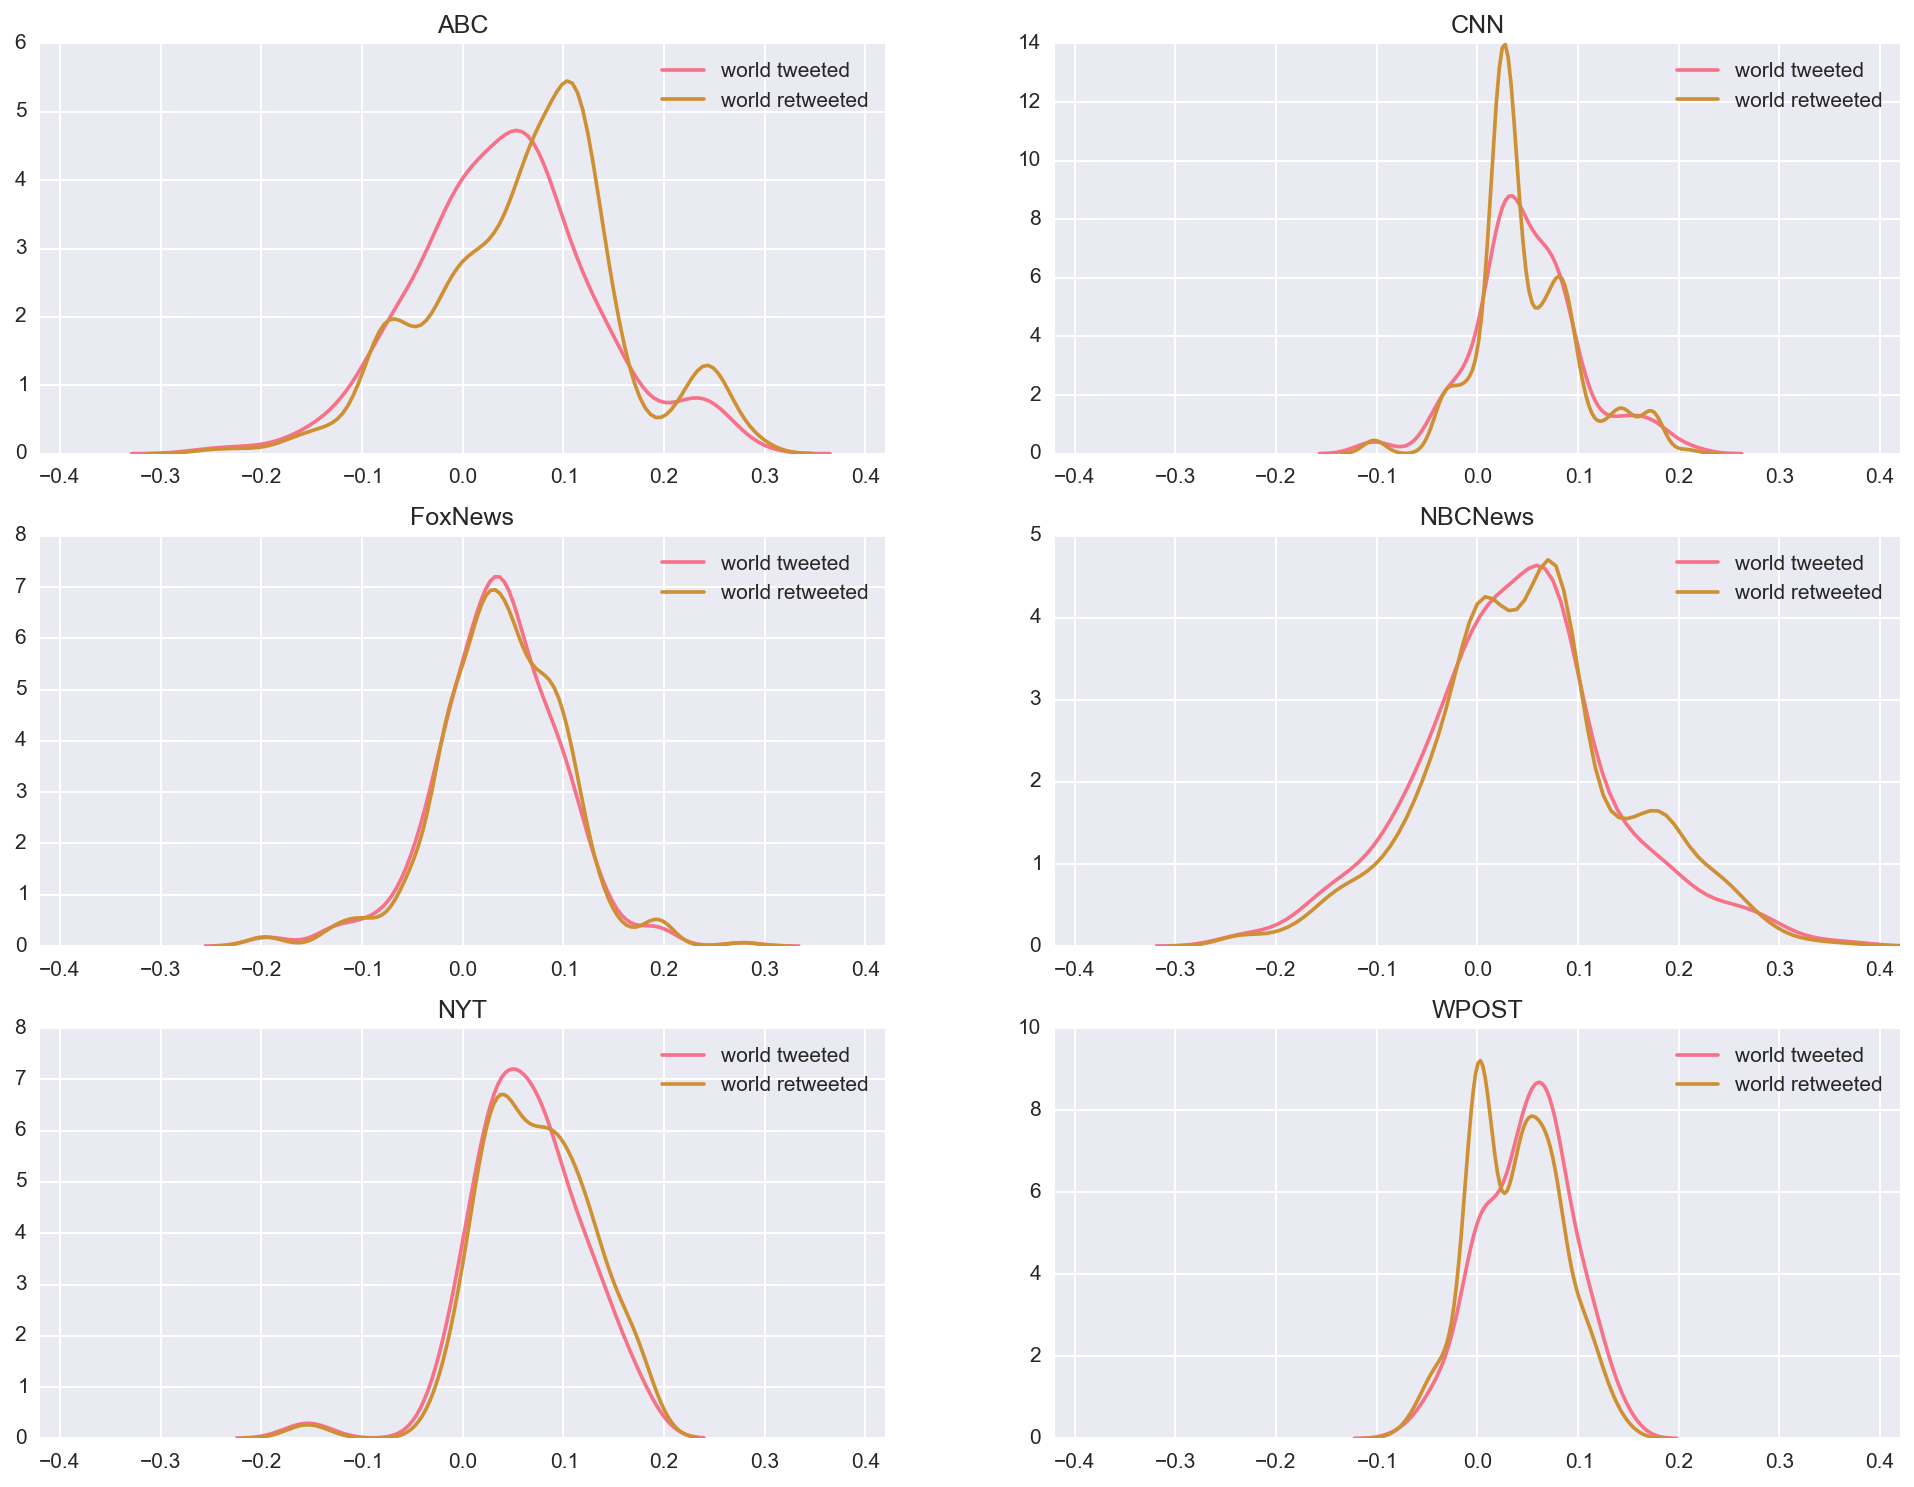

In [36]:
c='world'
f,axes = plt.subplots(nrows=3,ncols=2,figsize=(16,12),subplot_kw={'xlim': splim});#,sharex=True,sharey=True
for i,o in enumerate(outlets):
    ax = axes[i/2][i%2]
    ax.set_title(o)
    tw = df[(df['cats']==c) & (df['outlet']==o)]['sp']
    rt = rn[(rn['cats']==c) & (rn['outlet']==o)]['sp']
    sns.kdeplot(tw,label=c+' tweeted',ax=ax);
    sns.kdeplot(rt,label=c+' retweeted',ax=ax);

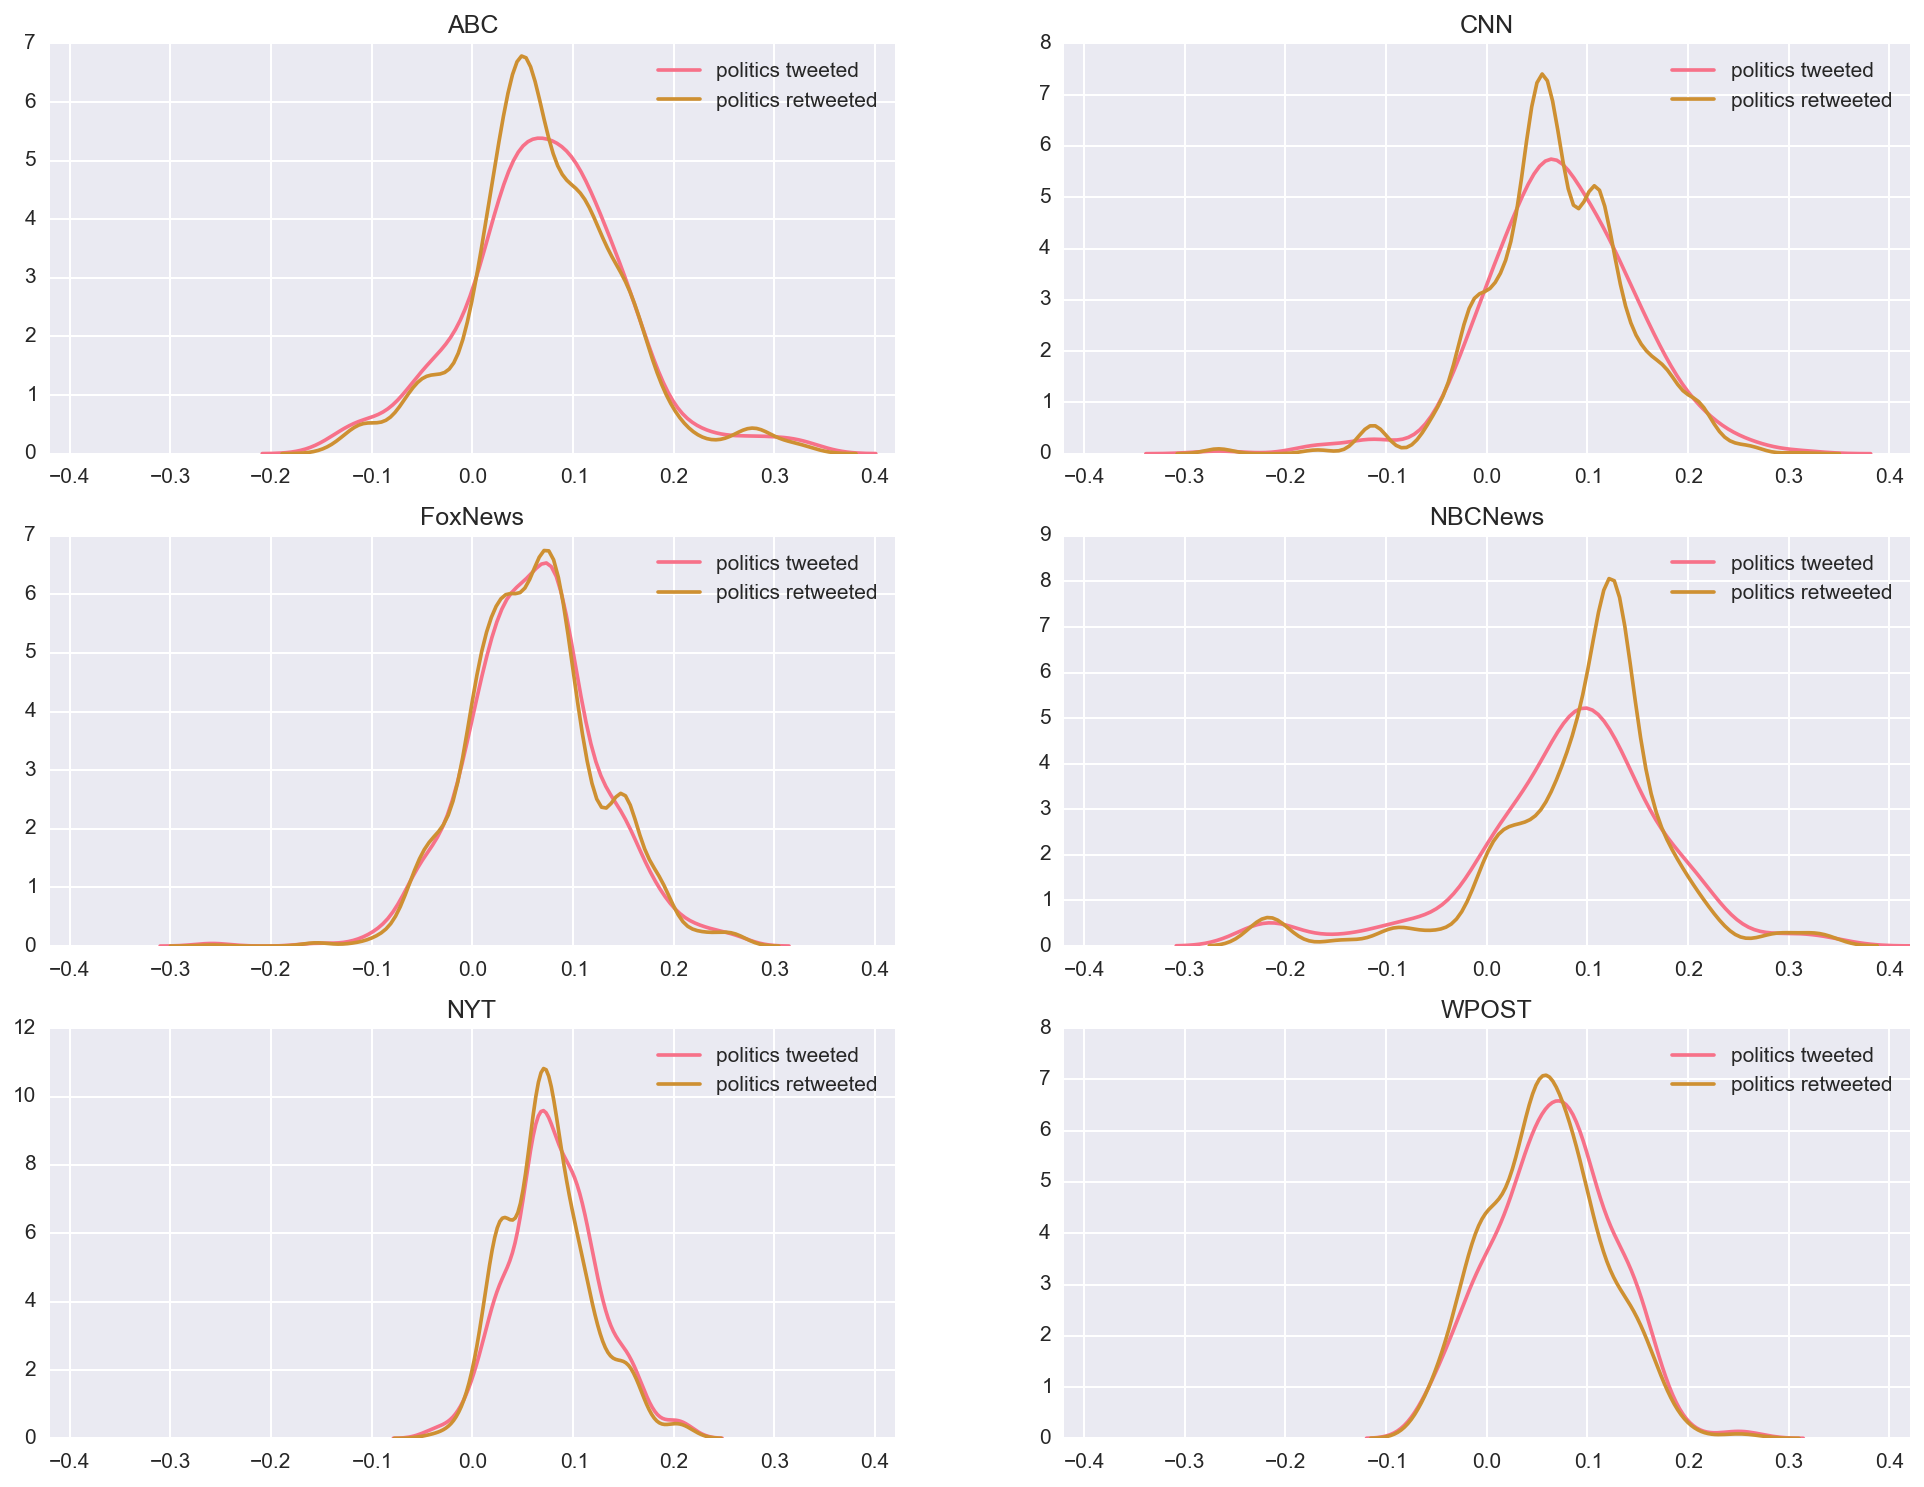

In [35]:
c='politics'
f,axes = plt.subplots(nrows=3,ncols=2,figsize=(16,12),subplot_kw={'xlim': splim});#,sharex=True,sharey=True
for i,o in enumerate(outlets):
    ax = axes[i/2][i%2]
    ax.set_title(o)
    tw = df[(df['cats']==c) & (df['outlet']==o)]['sp']
    rt = rn[(rn['cats']==c) & (rn['outlet']==o)]['sp']
    sns.kdeplot(tw,label=c+' tweeted',ax=ax);
    sns.kdeplot(rt,label=c+' retweeted',ax=ax);

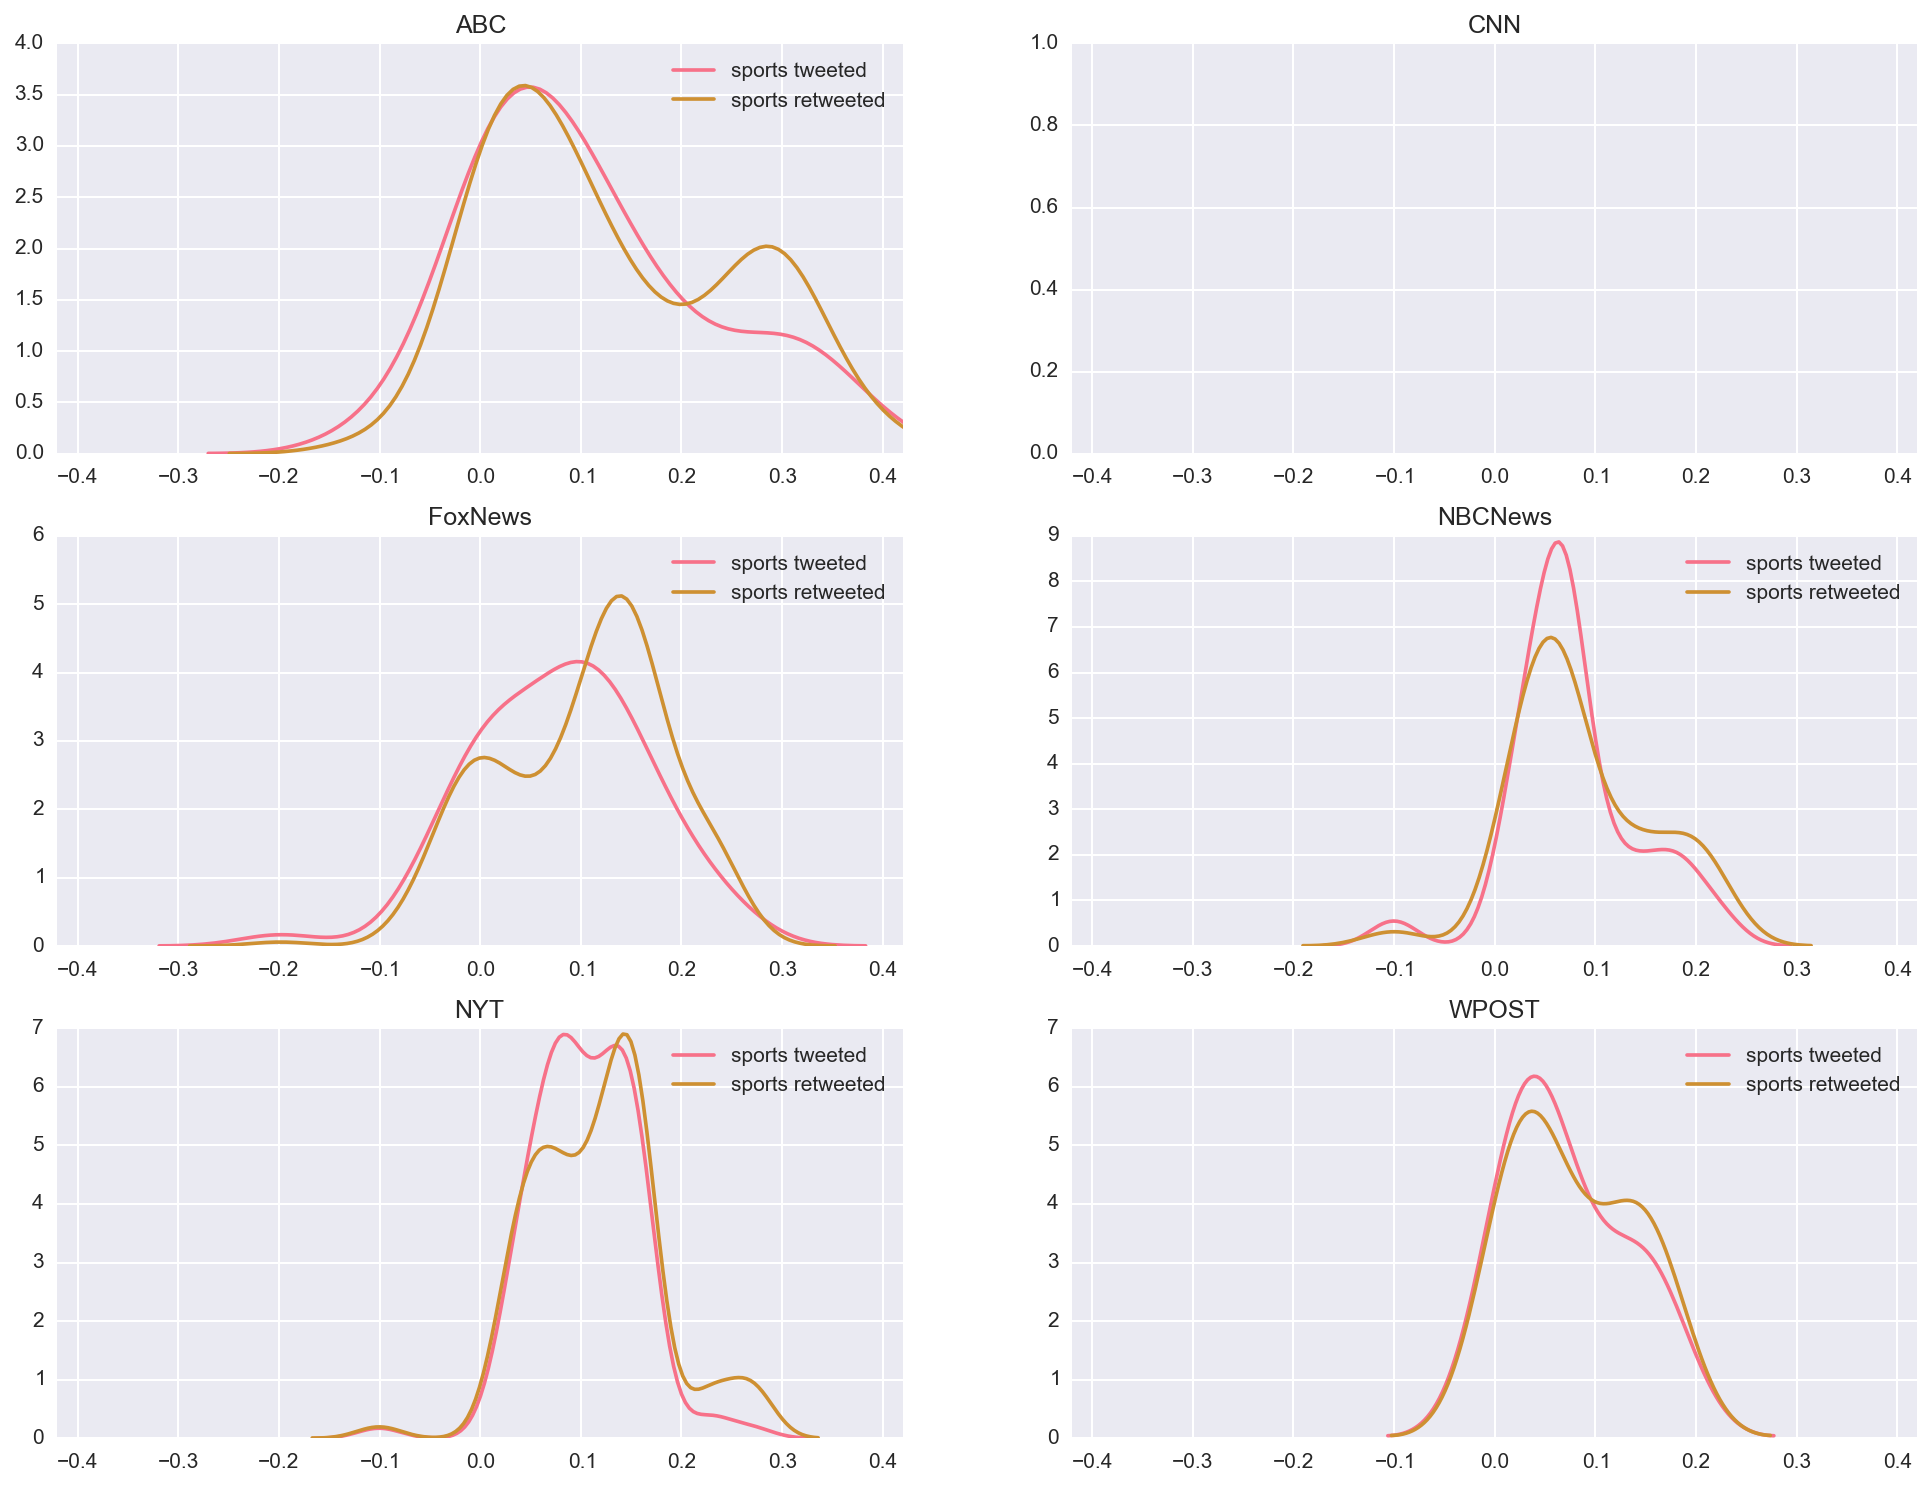

In [34]:
c='sports'
f,axes = plt.subplots(nrows=3,ncols=2,figsize=(16,12),subplot_kw={'xlim': splim});#,sharex=True,sharey=True
for i,o in enumerate(outlets):
    ax = axes[i/2][i%2]
    ax.set_title(o)
    if o == 'CNN': #CNN does not have sports category in our dataset
        continue
    tw = df[(df['cats']==c) & (df['outlet']==o)]['sp']
    rt = rn[(rn['cats']==c) & (rn['outlet']==o)]['sp']
    sns.kdeplot(tw,label=c+' tweeted',ax=ax);
    sns.kdeplot(rt,label=c+' retweeted',ax=ax);

In [82]:
tw = df[df['cats'].isin(cs)]
rt = rn[rn['cats'].isin(cs)]
sp = pd.DataFrame(pd.pivot_table(tw,index=['cats'],values='sp',aggfunc=np.mean)).rename(columns={'sp':'Tweeted'})
sp = sp.join(pd.pivot_table(rt,index=['cats'],values='sp',aggfunc=np.mean)).rename(columns={'sp':'Retweeted'})
sp.index.name ='Categories'
sp

,Tweeted,Retweeted
Categories,,
politics,0.068794,0.067125
sports,0.094705,0.111061
world,0.042384,0.049906


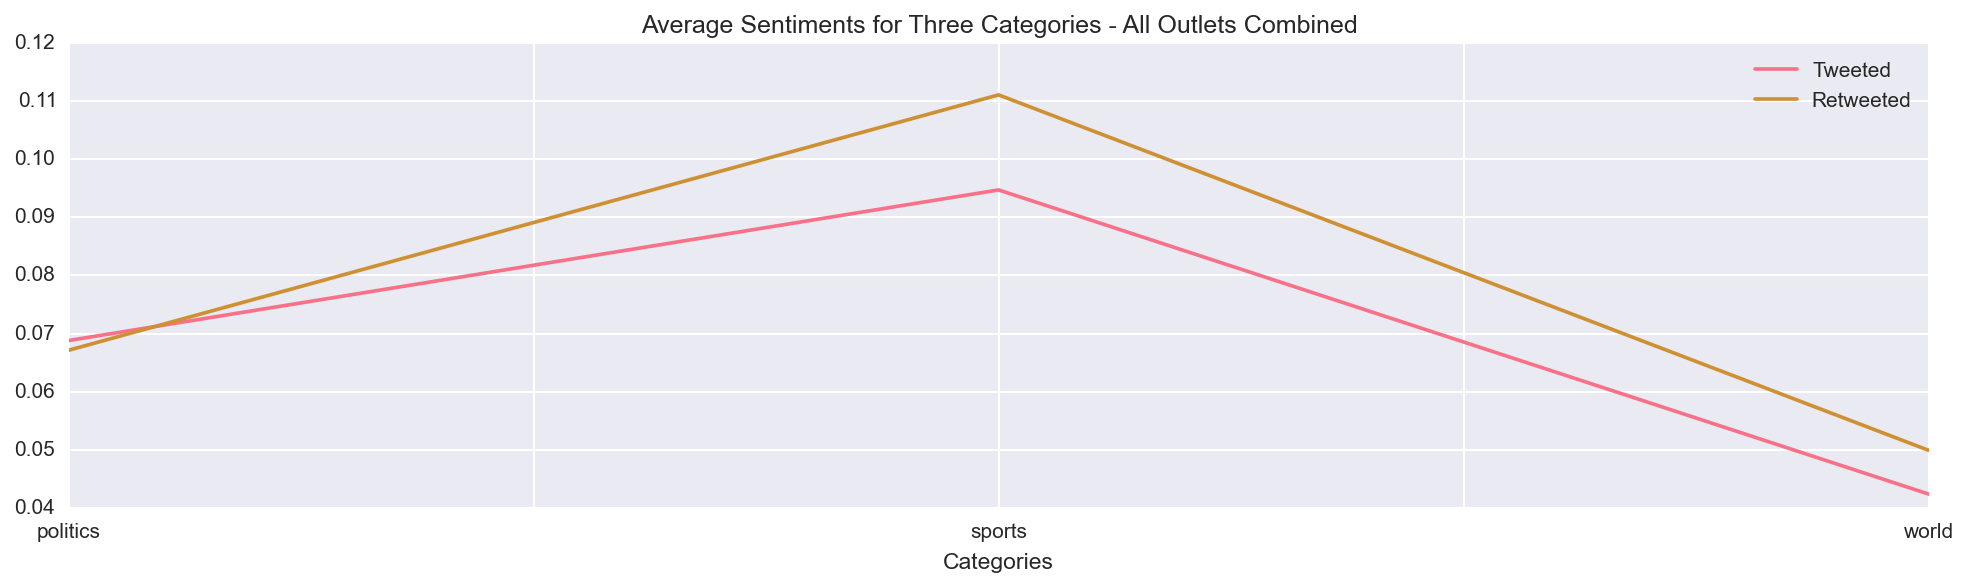

In [85]:
ax = sp.plot()
ax.set_title('Average Sentiments for Three Categories - All Outlets Combined');